# 3.6 Modelo de Clasificación Random Forest
### Miguel Ángel Jiménez Cuadrillero
### 2020

# Dataset

Para esta sección vamos a utilizar el famolo dataset de pasajeros del Titanic, muy habitual en competiciones en Kaggle. https://www.kaggle.com/c/titanic/data


* survival:	Survival	0 = No, 1 = Yes
* pclass:	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
* sex:	Sex	
* Age:	Age in years	
* sibsp:	# of siblings / spouses aboard the Titanic	
* parch:	# of parents / children aboard the Titanic	
* ticket:	Ticket number	
* fare:	Passenger fare	
* cabin:	Cabin number	
* embarked: Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton


### Variable Notes

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

*OBJETIVO*: Queremos predecir que pasajero va a sobrevivir en base a sus características.

In [74]:
import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
random_state = 42

## Carga de datos

In [21]:
train = pd.read_csv("./datasets/titanic/train.csv", sep=',')
test = pd.read_csv("./datasets/titanic/test.csv", sep=',')

## Análisis Exploratorio de Datos

In [22]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [23]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [24]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


## Estudio numérico de datos

In [25]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Existen 11 columnas o features más una variable objetivo o clase llamada Survived que es binaria. Estamos ante un problema de clasificación binaria.

Pclass, Sex y Embarked son Variables Categóricas

Age, SibSp, Parch and Fare son Variables Numéricas Continuas

## Visualización de Datos

Crearemos múltiples visualizaciones para entender las relaciones de los datos, profundizar en su comprensión y buscar oportunidades de Feature Engineering

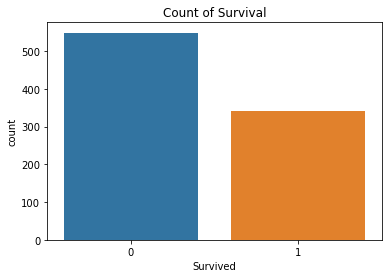

In [26]:
fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='Survived', data=train)
plt.title("Count of Survival")
plt.show()

In [27]:
n=len(train)
surv_0=len(train[train['Survived']==0])
surv_1=len(train[train['Survived']==1])

print("% of pasajeros supervivientes en train dataset: ",surv_1*100/n)
print("% of pasajeros supervivientes en train dataset: ",surv_0*100/n)

% of pasajeros supervivientes en train dataset:  38.38383838383838
% of pasajeros supervivientes en train dataset:  61.61616161616162


## Interpretación preliminar sobre la variable a predecir

Las clases están un poco desbalanceadas, y se puede dar el caso de que si no hacemos nada y supusiéramos que todos los pasajeros mueren, tendríamos una precisión del 61.6% (Accuracy Paradox)

## Estudio de la Correlación de las Variables

En primer lugar separamos las variables por su naturaleza.

In [28]:
categorical_var = ['Pclass','Sex','Embarked']
numeric_var = ['Age','SibSp','Parch','Fare']

In [29]:
corr_df = train[numeric_var] 
cor = corr_df.corr(method='pearson')
print(cor)

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


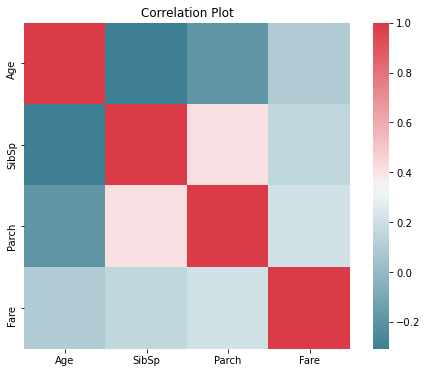

In [30]:
fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

No hay una fuerte correlación entre dos variables. La correlación más fuerte es entre las características SibSp y Parch (0.414).

Mantenemos todas las features ya que no hay pruebas sólidas de redundancia de datos.

Usemos la prueba de chi-cuadrado para comprender la relación entre las variables categóricas y la variable objetivo

In [31]:
csq = chi2_contingency(pd.crosstab(train['Survived'], train['Sex']))
print("P-value: ", csq[1])

P-value:  1.1973570627755645e-58


In [32]:
csq2 = chi2_contingency(pd.crosstab(train['Survived'], train['Embarked']))
print("P-value: ", csq2[1])

P-value:  1.769922284120912e-06


In [33]:
csq3 = chi2_contingency(pd.crosstab(train['Survived'], train['Pclass']))
print("P-value: ", csq3[1])

P-value:  4.549251711298793e-23


P values para las features Sex, Embarked y Pclass es muy pequeño por lo que podemos refutar la hipótesis nula que es que estas features son independientes y no tienen relacion con la variable target a predecir, es decir, estas features contribuyen con información para predecir la variable objetivo, es decir, tienen capacidad predictora.

Graficamente:

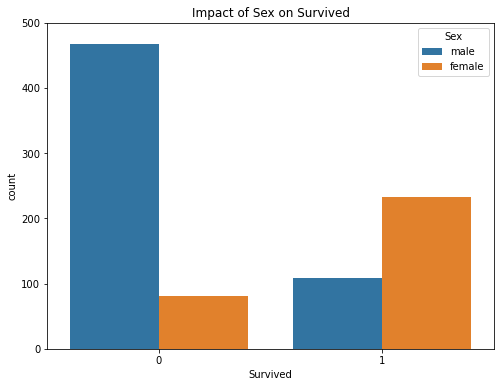

In [34]:
fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='Survived', data=train, hue='Sex')
ax.set_ylim(0,500)
plt.title("Impact of Sex on Survived")
plt.show()

Podemos decir que las mujeres pasajeros tienen mayor probabilidad de supervivencia que los hombres.

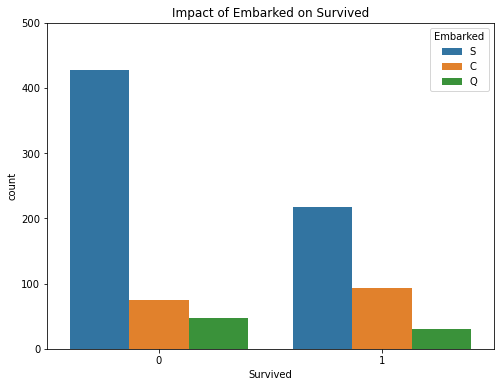

In [36]:
fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='Survived', data=train, hue='Embarked')
ax.set_ylim(0,500)
plt.title("Impact of Embarked on Survived")
plt.show()

La proporción de pasajeros sobrevivientes y no sobrevivientes para S y Q embarcados es similar, pero los pasajeros de C embarcados tienen mayores posibilidades de supervivencia.

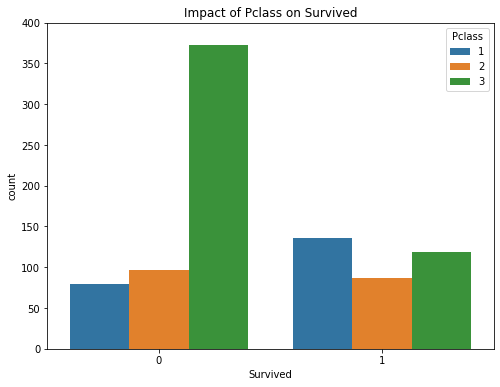

In [37]:
fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='Survived', data=train, hue='Pclass')
ax.set_ylim(0,400)
plt.title("Impact of Pclass on Survived")
plt.show()

Los pasajeros de Pclass 3 tienen menos posibilidades de supervivencia, mientras que los pasajeros de Pclass 1 tienen mayores posibilidades de supervivencia.

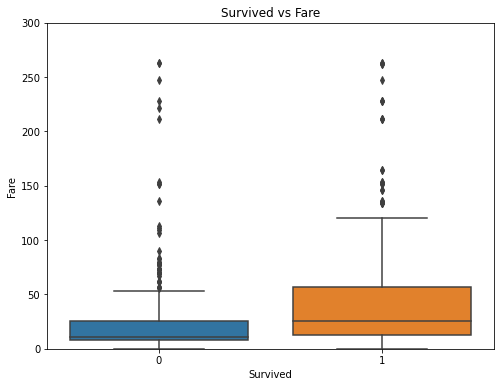

In [38]:
fig, ax=plt.subplots(1,figsize=(8,6))
sns.boxplot(x='Survived',y='Fare', data=train)
ax.set_ylim(0,300)
plt.title("Survived vs Fare")
plt.show()

La tarifa promedio para los pasajeros que sobrevivieron es más alta que la que no sobrevivió.

## Gestión de Missing Values

Veamos qué características contienen valores perdidos

In [40]:
print(train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [41]:
print(test.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [43]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

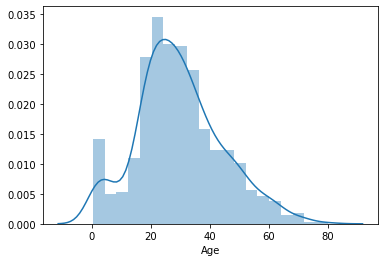

In [46]:
sns.distplot(train['Age'])

La edad tiene una distribución similar a una normal, aún asi imputamos con la mediana por que esta un poco sesgada.

In [47]:
med=np.nanmedian(train['Age'])
train['Age']=train['Age'].fillna(med)
test['Age']=test['Age'].fillna(med)

In [48]:
train['Cabin'].value_counts()

C23 C25 C27    4
B96 B98        4
G6             4
F33            3
C22 C26        3
              ..
E38            1
D19            1
C106           1
F E69          1
A34            1
Name: Cabin, Length: 147, dtype: int64

In [59]:
train['Cabin']=train['Cabin'].fillna(0)
test['Cabin']=test['Cabin'].fillna(0)

In [60]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Reemplazamos con la moda, el más repetido

In [61]:
train['Cabin']=train['Cabin'].fillna("S")

In [62]:
train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [63]:
med=np.nanmedian(train['Fare'])
test['Fare']=test['Fare'].fillna(med)

## Feature Engineering

In [64]:
train['hasCabin']=train['Cabin'].apply(lambda x: 0 if x==0 else 1)
test['hasCabin']=test['Cabin'].apply(lambda x: 0 if x==0 else 1)

In [65]:
train['FamilyMem']=train.apply(lambda x: x['SibSp']+x['Parch'], axis=1)
test['FamilyMem']=test.apply(lambda x: x['SibSp']+x['Parch'], axis=1)

In [66]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""
train['title']=train['Name'].apply(get_title)
test['title']=test['Name'].apply(get_title)

In [67]:
title_lev1=list(train['title'].value_counts().reset_index()['index'])
title_lev2=list(test['title'].value_counts().reset_index()['index'])
title_lev=list(set().union(title_lev1, title_lev2))
print(title_lev)

['Sir', 'Don', 'Major', 'Mrs', 'Dona', 'Countess', 'Lady', 'Mme', 'Col', 'Miss', 'Capt', 'Dr', 'Mlle', 'Jonkheer', 'Ms', 'Master', 'Rev', 'Mr']


In [69]:
train['title']=pd.Categorical(train['title'], categories=title_lev)
test['title']=pd.Categorical(test['title'], categories=title_lev)
cols=['Pclass','Sex','Embarked','hasCabin','title']
fcol=['Pclass','Sex','Embarked','hasCabin','title','Age','FamilyMem','Fare']
for c in cols:
    train[c]=train[c].astype('category')
    test[c]=test[c].astype('category')

In [70]:
train_df=train[fcol]
test_df=test[fcol]
train_df=pd.get_dummies(train_df, columns=cols, drop_first=True)
test_df=pd.get_dummies(test_df, columns=cols, drop_first=True)

In [75]:
y=train['Survived']
x_train, x_test, y_train, y_test = train_test_split(train_df, y, test_size=0.3, random_state=random_state)

rfc=RandomForestClassifier(random_state=random_state)
param_grid = { 
    'n_estimators': [200, 300, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)

CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 500}

In [76]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=8, criterion='gini')
rfc1.fit(x_train, y_train)
pred=rfc1.predict(x_test)

In [77]:
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))

Accuracy for Random Forest on CV data:  0.8022388059701493
